In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
from datetime import datetime, timedelta
import yfinance as yf
from IPython.display import display
from lets_plot import *

from IPython.display import display
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA #non-linear model, alternatively, t-stochastic neighborhood embedding, UMAP

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix
from lets_plot import *
LetsPlot.setup_html()  # Enable Lets-Plot for notebooks
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
# jupytext --set-formats ipynb,py:percent "notebook.ipynb" --sync
# jupytext --set-formats ipynb,py:percent "script.py" --sync
# jupytext --set-formats ipynb,py:percent "QF627_PyDay_Week7_Problem_Set_8_Review.ipynb" --sync

# jupytext --set-formats ipynb,py:percent "QF627_PyDay_Week7_Problem_Set_8_Review.py" --sync
from codebase import *

In [2]:
import os

cache_file = "spy_raw_cache.csv"

if os.path.exists(cache_file):
    spy_raw = pd.read_csv(cache_file, index_col=0, parse_dates=True)
else:
    spy_raw = (
        yf
        .download(["SPY"],
                  start=dt.datetime(2006, 11, 1),
                  end=dt.datetime(2025, 11, 13),
                  auto_adjust=True
                 )
    )
    
    # Ensure index is datetime and is one-level
    spy_raw.index = pd.to_datetime(spy_raw.index)
    display(spy_raw)

    # Convert to 1-level columns if necessary
    if spy_raw.columns.nlevels > 1:
        spy_raw.columns = spy_raw.columns.droplevel(1)
    print("columns: ", spy_raw.columns.nlevels)
    display(spy_raw)

    spy_raw.to_csv(cache_file)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-11-01,95.973633,96.990449,95.875458,96.927339,83005600
2006-11-02,95.917480,96.078766,95.622955,95.728139,60693100
2006-11-03,95.749168,96.345238,95.104016,96.261091,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400


columns:  1


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973633,96.990449,95.875458,96.927339,83005600
2006-11-02,95.917480,96.078766,95.622955,95.728139,60693100
2006-11-03,95.749168,96.345238,95.104016,96.261091,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900


In [3]:

spy = spy_raw.copy()
spy["Adj_Close"] = spy["Close"]

display(spy)

Price,Close,High,Low,Open,Volume,Adj_Close
Date,,,,,,
2006-11-01,95.973633,96.990449,95.875458,96.927339,83005600,95.973633
2006-11-02,95.917480,96.078766,95.622955,95.728139,60693100,95.917480
2006-11-03,95.749168,96.345238,95.104016,96.261091,71346400,95.749168
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300,96.829132
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900,97.200813
...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,670.309998
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,670.969971
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,681.440002


In [4]:
def compute_mean_reversion_strategy(df, window=20, position_size=150, initial_cash=100000, 
                                   z_threshold_long=-2.0, z_threshold_short=2.0,
                                   position_sizing_method='fixed', capital_allocation_pct=0.95):
    """
    Compute mean reversion strategy based on z-score signals.

    Parameters:
    -----------
    df : DataFrame with 'Adj_Close' column
    window : int, rolling window for SMA and StdDev (default=20)
    position_size : int, number of shares per trade when using 'fixed' method (default=150)
    initial_cash : float, starting capital (default=100000)
    z_threshold_long : float, z-score threshold for long entry (default=-2.0)
    z_threshold_short : float, z-score threshold for short entry (default=2.0)
    position_sizing_method : str, either 'fixed' or 'capital_based' (default='fixed')
        - 'fixed': uses fixed position_size parameter
        - 'capital_based': calculates max shares based on available capital
    capital_allocation_pct : float, percentage of available capital to use per trade (default=0.95)
        Only applies when position_sizing_method='capital_based'

    Returns:
    --------
    DataFrame with signals, positions, PnL calculations, and portfolio tracking
    """
    df_signals = df.copy()
    # ============================================================
    # 1. Calculate Technical Indicators
    # ============================================================
    df_signals['dynamic_sma'] = df_signals['Adj_Close'].rolling(
        window=window, min_periods=1, center=False
    ).mean()

    df_signals['dynamic_std'] = df_signals['Adj_Close'].rolling(
        window=window, min_periods=1, center=False
    ).std()
    df_signals['dynamic_std'] = df_signals['dynamic_std'].replace(0, np.nan)

    df_signals['z_score'] = (
        (df_signals['Adj_Close'] - df_signals['dynamic_sma']) / df_signals['dynamic_std']
    )
    df_signals['z_score'] = df_signals['z_score'].replace([np.inf, -np.inf], np.nan).fillna(0)
    std_for_bands = df_signals['dynamic_std'].fillna(0)
    
    df_signals['range_upper'] = df_signals['dynamic_sma'] + z_threshold_short * std_for_bands
    df_signals['range_lower'] = df_signals['dynamic_sma'] + z_threshold_long * std_for_bands 
    
    # ============================================================
    # 2. Generate Entry/Exit Signals
    # ============================================================
    # Entry Long: z[t-1] > z_threshold_long AND z[t] <= z_threshold_long (crosses down through threshold)
    df_signals['entry_long'] = (
        (df_signals['z_score'].shift(1) > z_threshold_long) &
        (df_signals['z_score'] <= z_threshold_long)
    )

    # Exit Long: z[t-1] < 0 AND z[t] >= 0 (crosses up through 0)
    df_signals['exit_long'] = (
        (df_signals['z_score'].shift(1) < 0) &
        (df_signals['z_score'] >= 0)
    )

    # Entry Short: z[t-1] < z_threshold_short AND z[t] >= z_threshold_short (crosses up through threshold)
    df_signals['entry_short'] = (
        (df_signals['z_score'].shift(1) < z_threshold_short) &
        (df_signals['z_score'] >= z_threshold_short)
    )

    # Exit Short: z[t-1] > 0 AND z[t] <= 0 (crosses down through 0)
    df_signals['exit_short'] = (
        (df_signals['z_score'].shift(1) > 0) &
        (df_signals['z_score'] <= 0)
    )

    # ============================================================
    # 3. Calculate Position State and Portfolio Tracking
    # ============================================================
    # Position states: 0 = flat, 1 = long, -1 = short
    positions = []
    shares_held = []
    cash_balance = []
    equity_value = []
    total_portfolio = []
    
    current_position = 0
    current_shares = 0
    current_cash = initial_cash

    for i in range(len(df_signals)):
        price = df_signals.iloc[i]['Adj_Close']
        
        # First (window-1) days: no positions (indicator lookback period)
        if i < window - 1:
            positions.append(0)
            shares_held.append(0)
            cash_balance.append(current_cash)
            equity_value.append(0)
            total_portfolio.append(current_cash)
            continue

        # Process exit signals first (priority)
        if current_position == 1 and df_signals.iloc[i]['exit_long']:
            # Exit long: sell shares
            current_cash += current_shares * price
            current_shares = 0
            current_position = 0
            
        elif current_position == -1 and df_signals.iloc[i]['exit_short']:
            # Exit short: buy back shares to cover
            current_cash += current_shares * price  # current_shares is negative for short
            current_shares = 0
            current_position = 0
            
        # Process entry signals (only if flat)
        elif current_position == 0:
            if df_signals.iloc[i]['entry_long']:
                # Enter long position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = int(available_capital / price)
                else:
                    # Use fixed position size
                    current_shares = position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares > 0:
                    current_cash -= current_shares * price
                    current_position = 1
                else:
                    current_shares = 0
                    
            elif df_signals.iloc[i]['entry_short']:
                # Enter short position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = -int(available_capital / price)  # Negative for short
                else:
                    # Use fixed position size (negative for short)
                    current_shares = -position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares < 0:
                    current_cash -= current_shares * price  # Subtracting negative adds to cash
                    current_position = -1
                else:
                    current_shares = 0

        # Record state
        positions.append(current_position)
        shares_held.append(current_shares)
        cash_balance.append(current_cash)
        
        # Calculate equity value (mark-to-market)
        equity = current_shares * price
        equity_value.append(equity)
        total_portfolio.append(current_cash + equity)

    df_signals['signal'] = positions
    df_signals['shares'] = shares_held
    df_signals['cash'] = cash_balance
    df_signals['equity'] = equity_value
    df_signals['portfolio_value'] = total_portfolio

    # ============================================================
    # 4. Calculate Returns and PnL
    # ============================================================
    df_signals['returns'] = df_signals['Adj_Close'].pct_change()
    df_signals['position'] = df_signals['signal'].shift(1).fillna(0)
    df_signals['strategy_returns'] = df_signals['returns'] * df_signals['position']       

    # Calculate daily PnL from portfolio value changes
    df_signals['pnl'] = df_signals['portfolio_value'].diff()
    
    # Calculate cumulative PnL
    df_signals['cumulative_pnl'] = df_signals['portfolio_value'] - initial_cash

    return df_signals

In [5]:
def hyperparameter_test(df, 
                       window_range=[10, 20, 30, 50],
                       z_threshold_long_range=[-2.5, -2.0, -1.5, -1.0],
                       z_threshold_short_range=[1.0, 1.5, 2.0, 2.5],
                       position_sizing_methods=['fixed', 'capital_based'],
                       position_sizes=[150],
                       capital_allocation_pcts=[0.98],
                       initial_cash=100000,
                       sort_by='Sharpe Ratio',
                       top_n=20,
                       verbose=True,
                       n_jobs=-1):
    """
    Test multiple hyperparameter combinations for the mean reversion strategy with PARALLEL PROCESSING.
    
    Parameters:
    -----------
    df : DataFrame with 'Adj_Close' column
    window_range : list of int, rolling window values to test
    z_threshold_long_range : list of float, long entry thresholds (negative values)
    z_threshold_short_range : list of float, short entry thresholds (positive values)
    position_sizing_methods : list of str, methods to test ['fixed', 'capital_based']
    position_sizes : list of int, position sizes for 'fixed' method
    capital_allocation_pcts : list of float, allocation % for 'capital_based' method
    initial_cash : float, starting capital
    sort_by : str, metric to sort results by (default='Sharpe Ratio')
    top_n : int, number of top results to return (default=20)
    verbose : bool, print progress updates
    n_jobs : int, number of parallel jobs (-1 uses all cores, 1 for sequential, default=-1)
    
    Returns:
    --------
    DataFrame with results sorted by specified metric
    """
    import itertools
    from datetime import datetime
    from joblib import Parallel, delayed
    import io
    import sys
    
    results = []
    
    # Generate all parameter combinations
    param_combinations = []
    
    for window in window_range:
        for z_long in z_threshold_long_range:
            for z_short in z_threshold_short_range:
                # Only test valid threshold combinations (short > long in absolute value makes sense)
                if z_short > abs(z_long):
                    for method in position_sizing_methods:
                        if method == 'fixed':
                            for pos_size in position_sizes:
                                param_combinations.append({
                                    'window': window,
                                    'z_threshold_long': z_long,
                                    'z_threshold_short': z_short,
                                    'position_sizing_method': method,
                                    'position_size': pos_size,
                                    'capital_allocation_pct': None
                                })
                        else:  # capital_based
                            for cap_alloc in capital_allocation_pcts:
                                param_combinations.append({
                                    'window': window,
                                    'z_threshold_long': z_long,
                                    'z_threshold_short': z_short,
                                    'position_sizing_method': method,
                                    'position_size': None,
                                    'capital_allocation_pct': cap_alloc
                                })
    
    # Helper function to test a single parameter combination
    def test_single_combination(params):
        try:
            # Run strategy
            if params['position_sizing_method'] == 'fixed':
                df_signals = compute_mean_reversion_strategy(
                    df,
                    window=params['window'],
                    position_size=params['position_size'],
                    initial_cash=initial_cash,
                    z_threshold_long=params['z_threshold_long'],
                    z_threshold_short=params['z_threshold_short'],
                    position_sizing_method=params['position_sizing_method']
                )
            else:  # capital_based
                df_signals = compute_mean_reversion_strategy(
                    df,
                    window=params['window'],
                    initial_cash=initial_cash,
                    z_threshold_long=params['z_threshold_long'],
                    z_threshold_short=params['z_threshold_short'],
                    position_sizing_method=params['position_sizing_method'],
                    capital_allocation_pct=params['capital_allocation_pct']
                )
            
            # Calculate metrics (suppress print output)
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()
            
            metrics = calculate_performance_metrics(df_signals, initial_cash=initial_cash)
            
            sys.stdout = old_stdout
            
            # Store results
            result = {
                'Window': params['window'],
                'Z_Long': params['z_threshold_long'],
                'Z_Short': params['z_threshold_short'],
                'Method': params['position_sizing_method'],
                'Position_Size': params['position_size'],
                'Capital_Alloc_Pct': params['capital_allocation_pct'],
                **metrics  # Add all metrics
            }
            return result
        
        except Exception as e:
            return None
    
    total_tests = len(param_combinations)
    if verbose:
        print(f"\n{'='*70}")
        print(f"HYPERPARAMETER TEST - PARALLEL PROCESSING")
        print(f"{'='*70}")
        print(f"Testing {total_tests} parameter combinations...")
        print(f"Using {n_jobs if n_jobs > 0 else 'ALL'} CPU cores")
        print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
        print(f"{'='*70}\n")
    
    # Run tests in parallel
    results = Parallel(n_jobs=n_jobs, verbose=10 if verbose else 0)(
        delayed(test_single_combination)(params) for params in param_combinations
    )
    
    # Filter out None results (failed tests)
    results = [r for r in results if r is not None]
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"\nCompleted at: {datetime.now().strftime('%H:%M:%S')}")
        print(f"Successful tests: {len(results_df)}/{total_tests}")
    
    # Sort by specified metric (descending for most metrics)
    if sort_by in results_df.columns:
        ascending = True if 'Drawdown' in sort_by else False  # Drawdown should be ascending (less negative is better)
        results_df = results_df.sort_values(by=sort_by, ascending=ascending)
    
    # Return top N results
    return results_df.head(top_n) if top_n else results_df

In [6]:
def calculate_performance_metrics(df_signals, initial_cash=100000):
    """
    Calculate comprehensive performance metrics for the mean reversion strategy.

    Parameters:
    -----------
    df_signals : DataFrame returned from compute_mean_reversion_strategy()
    initial_cash : float, starting capital (default=100000)

    Returns:
    --------
    Dictionary with performance metrics
    """
    # Calculate signal changes to identify individual trades
    df_signals['signal_change'] = df_signals['signal'].diff()

    # Identify trade periods (when position is held)
    df_long = df_signals[df_signals['signal'] == 1].copy()
    df_short = df_signals[df_signals['signal'] == -1].copy()

    # Calculate trade-level P&L by grouping consecutive positions
    trades = []
    current_signal = 0
    entry_idx = None

    for idx, row in df_signals.iterrows():
        if row['signal'] != current_signal:
            # Position changed - close previous trade if exists
            if current_signal != 0 and entry_idx is not None:
                exit_idx = idx
                trade_pnl = df_signals.loc[entry_idx:idx, 'pnl'].sum()
                trades.append({
                    'entry_date': entry_idx,
                    'exit_date': exit_idx,
                    'direction': 'Long' if current_signal == 1 else 'Short',
                    'pnl': trade_pnl
                })

            # Start new trade if entering position
            if row['signal'] != 0:
                entry_idx = idx
            current_signal = row['signal']

    # Convert to DataFrame
    trades_df = pd.DataFrame(trades)

    # Separate by direction and win/loss
    if len(trades_df) > 0:
        winning_longs = trades_df[(trades_df['direction'] == 'Long') & (trades_df['pnl'] > 0)]
        losing_longs = trades_df[(trades_df['direction'] == 'Long') & (trades_df['pnl'] <= 0)]
        winning_shorts = trades_df[(trades_df['direction'] == 'Short') & (trades_df['pnl'] > 0)]
        losing_shorts = trades_df[(trades_df['direction'] == 'Short') & (trades_df['pnl'] <= 0)]
    else:
        winning_longs = losing_longs = winning_shorts = losing_shorts = pd.DataFrame()

    # Calculate total returns
    # Use portfolio_value if available (more accurate), otherwise calculate from pnl
    if 'portfolio_value' in df_signals.columns:
        final_value = df_signals['portfolio_value'].iloc[-1]
        total_pnl = final_value - initial_cash
    else:
        total_pnl = df_signals['pnl'].sum()
        final_value = initial_cash + total_pnl
    
    total_return_pct = (total_pnl / initial_cash) * 100

    # Calculate CAGR
    years = (df_signals.index[-1] - df_signals.index[0]).days / 365.25
    cagr = ((final_value / initial_cash) ** (1 / years) - 1) * 100 if years > 0 else 0

    # Calculate Sharpe Ratio (annualized)
    daily_returns = df_signals['strategy_returns'].dropna()
    if len(daily_returns) > 0 and daily_returns.std() > 0:
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0

    # Calculate Max Drawdown
    cumulative_returns = (1 + df_signals['strategy_returns']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() * 100

    # Calculate volatility (annualized)
    volatility = daily_returns.std() * np.sqrt(252) * 100 if len(daily_returns) > 0 else 0

    # Calculate final P&L by direction
    final_long_pnl = (winning_longs['pnl'].sum() if len(winning_longs) > 0 else 0) + \
                     (losing_longs['pnl'].sum() if len(losing_longs) > 0 else 0)
    final_short_pnl = (winning_shorts['pnl'].sum() if len(winning_shorts) > 0 else 0) + \
                      (losing_shorts['pnl'].sum() if len(losing_shorts) > 0 else 0)

    # Compile metrics
    metrics = {
        'Total P&L ($)': total_pnl,
        'Total Return (%)': total_return_pct,
        'CAGR (%)': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Volatility (% annualized)': volatility,
        'Total Trades': len(trades_df),
        'Winning Longs': len(winning_longs),
        'Winning Longs P&L ($)': winning_longs['pnl'].sum() if len(winning_longs) > 0 else 0,
        'Losing Longs': len(losing_longs),
        'Losing Longs P&L ($)': losing_longs['pnl'].sum() if len(losing_longs) > 0 else 0,
        'Final Long P&L ($)': final_long_pnl,
        'Long Win Rate (%)': (len(winning_longs) / (len(winning_longs) + len(losing_longs)) * 100) if (len(winning_longs) + len(losing_longs)) > 0 else 0,
        'Winning Shorts': len(winning_shorts),
        'Winning Shorts P&L ($)': winning_shorts['pnl'].sum() if len(winning_shorts) > 0 else 0,
        'Losing Shorts': len(losing_shorts),
        'Losing Shorts P&L ($)': losing_shorts['pnl'].sum() if len(losing_shorts) > 0 else 0,
        'Final Short P&L ($)': final_short_pnl,
        'Short Win Rate (%)': (len(winning_shorts) / (len(winning_shorts) + len(losing_shorts)) * 100) if (len(winning_shorts) + len(losing_shorts)) > 0 else 0,
    }

    # Print formatted summary
    print(f"\n{'='*70}")
    print(f"{'PERFORMANCE METRICS SUMMARY':^70}")
    print(f"{'='*70}\n")

    print(f"{'OVERALL PERFORMANCE':-^70}")
    print(f"Total P&L:                ${metrics['Total P&L ($)']:>15,.2f}")
    print(f"Total Return:             {metrics['Total Return (%)']:>15,.2f}%")
    print(f"CAGR:                     {metrics['CAGR (%)']:>15,.2f}%")
    print(f"Sharpe Ratio:             {metrics['Sharpe Ratio']:>15,.3f}")
    print(f"Max Drawdown:             {metrics['Max Drawdown (%)']:>15,.2f}%")
    print(f"Volatility (annualized):  {metrics['Volatility (% annualized)']:>15,.2f}%")
    print(f"\n{'TRADE STATISTICS':-^70}")
    print(f"Total Trades:             {metrics['Total Trades']:>15,}")
    print(f"\n{'LONG POSITIONS':-^70}")
    print(f"Winning Longs:            {metrics['Winning Longs']:>15,} trades")
    print(f"Winning Longs P&L:        ${metrics['Winning Longs P&L ($)']:>15,.2f}")
    print(f"Losing Longs:             {metrics['Losing Longs']:>15,} trades")
    print(f"Losing Longs P&L:         ${metrics['Losing Longs P&L ($)']:>15,.2f}")
    print(f"Final Long P&L:           ${metrics['Final Long P&L ($)']:>15,.2f}")
    print(f"Long Win Rate:            {metrics['Long Win Rate (%)']:>15,.2f}%")
    print(f"\n{'SHORT POSITIONS':-^70}")
    print(f"Winning Shorts:           {metrics['Winning Shorts']:>15,} trades")
    print(f"Winning Shorts P&L:       ${metrics['Winning Shorts P&L ($)']:>15,.2f}")
    print(f"Losing Shorts:            {metrics['Losing Shorts']:>15,} trades")
    print(f"Losing Shorts P&L:        ${metrics['Losing Shorts P&L ($)']:>15,.2f}")
    print(f"Final Short P&L:          ${metrics['Final Short P&L ($)']:>15,.2f}")
    print(f"Short Win Rate:           {metrics['Short Win Rate (%)']:>15,.2f}%")
    print(f"\n{'='*70}\n")

    return metrics

In [7]:
def viz_backtest_mean_reversion(df_signals, start_date=None, end_date=None):
    """
    Visualize mean reversion strategy with entry/exit signals.

    Parameters:
    -----------
    df_signals : DataFrame returned from compute_mean_reversion_strategy()
    start_date : str or datetime, optional start date for zoom (e.g., '2020-01-01')
    end_date : str or datetime, optional end date for zoom (e.g., '2020-12-31')
    """
    # Filter by date range if specified
    df_plot = df_signals.copy()
    if start_date is not None:
        df_plot = df_plot[df_plot.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_plot = df_plot[df_plot.index <= pd.to_datetime(end_date)]

    plt.figure(figsize=[17, 6])

    # Plot price
    plt.plot(df_plot["Adj_Close"], label="Price = Adjusted Close")

    # Plot threshold bands
    plt.plot(df_plot["range_upper"], label="Upper Bound Threshold", ls="-.")
    plt.plot(df_plot["range_lower"], label="Lower Bound Threshold", ls="-.")

    # Plot moving average
    plt.plot(df_plot["dynamic_sma"], label="Dynamic SMA")

    # Calculate signal changes (actual trade executions)
    df_plot['signal_change'] = df_plot['signal'].diff()
    df_plot['prev_signal'] = df_plot['signal'].shift(1)

    # LONG Entry: signal changes to 1 (0→1 or -1→1)
    long_entries = df_plot[(df_plot['signal'] == 1) & (df_plot['prev_signal'] != 1)]
    if len(long_entries) > 0:
        long_entries["Adj_Close"].plot(label="Long Entry", style="g^", markersize=10)

    # LONG Exit: signal changes from 1 to something else
    long_exits = df_plot[(df_plot['prev_signal'] == 1) & (df_plot['signal'] != 1)]
    if len(long_exits) > 0:
        long_exits["Adj_Close"].plot(label="Long Exit", style="v", color="lightgreen", markersize=10)

    # SHORT Entry: signal changes to -1 (0→-1 or 1→-1)
    short_entries = df_plot[(df_plot['signal'] == -1) & (df_plot['prev_signal'] != -1)]
    if len(short_entries) > 0:
        short_entries["Adj_Close"].plot(label="Short Entry", style="rv", markersize=10)

    # SHORT Exit: signal changes from -1 to something else
    short_exits = df_plot[(df_plot['prev_signal'] == -1) & (df_plot['signal'] != -1)]
    if len(short_exits) > 0:
        short_exits["Adj_Close"].plot(label="Short Exit", style="^", color="lightcoral", markersize=10)

    plt.title("Mean Reversion Strategy - Backtesting with Buy & Sell Signals")
    plt.legend()
    plt.show()

In [8]:
def viz_backtest_returns(df_signals, initial_cash=100000):
    """
    Visualize cumulative returns: strategy vs buy-and-hold.

    Parameters:
    -----------
    df_signals : DataFrame returned from compute_mean_reversion_strategy()
    initial_cash : float, starting capital (default=100000)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[17, 10])

    # Calculate cumulative returns
    df_plot = df_signals.copy()

    # Strategy cumulative returns
    df_plot['cum_strategy_returns'] = (1 + df_plot['strategy_returns']).cumprod() - 1

    # Buy-and-hold cumulative returns
    df_plot['cum_asset_returns'] = (1 + df_plot['returns']).cumprod() - 1

    # Calculate running maximum for drawdown
    strategy_cummax = (1 + df_plot['strategy_returns']).cumprod().expanding().max()
    df_plot['drawdown'] = ((1 + df_plot['strategy_returns']).cumprod() - strategy_cummax) / strategy_cummax

    # Plot 1: Cumulative Returns
    df_plot[['cum_asset_returns', 'cum_strategy_returns']].dropna().plot(ax=ax1, linewidth=1.5)

    # Format y-axis as percentage
    from matplotlib.ticker import PercentFormatter
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    ax1.legend(['Buy & Hold', 'Mean Reversion Strategy'], loc='best')
    ax1.set_title('Cumulative Returns: Strategy vs Buy-and-Hold', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.grid(alpha=0.3)

    # Plot 2: Drawdown
    df_plot['drawdown'].plot(ax=ax2, color='red', linewidth=1.5)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown')
    ax2.grid(alpha=0.3)
    ax2.fill_between(df_plot.index, df_plot['drawdown'], 0, color='red', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [9]:
# Example 1: Fixed position sizing (original method)
spy_signals_fixed = compute_mean_reversion_strategy(
    spy, 
    window=20, 
    position_size=150,
    initial_cash=100000,
    position_sizing_method='fixed'
)
metrics = calculate_performance_metrics(spy_signals_fixed, initial_cash=100000)


                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      18,907.75
Total Return:                       18.91%
CAGR:                                0.91%
Sharpe Ratio:                       0.248
Max Drawdown:                      -36.16%
Volatility (annualized):            15.31%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                         155

----------------------------LONG POSITIONS----------------------------
Winning Longs:                         56 trades
Winning Longs P&L:        $      44,645.74
Losing Longs:                          20 trades
Losing Longs P&L:         $     -19,084.88
Final Long P&L:           $      25,560.86
Long Win Rate:                      73.68%

---------------------------SHORT POSITIONS----------------------------
Winning Shorts:                        46 trades
Winning Shorts P&L:   


                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      34,810.13
Total Return:                       34.81%
CAGR:                                1.58%
Sharpe Ratio:                       0.171
Max Drawdown:                      -38.52%
Volatility (annualized):            16.38%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                         266

----------------------------LONG POSITIONS----------------------------
Winning Longs:                        151 trades
Winning Longs P&L:        $     212,200.63
Losing Longs:                          37 trades
Losing Longs P&L:         $    -159,586.50
Final Long P&L:           $      52,614.13
Long Win Rate:                      80.32%

---------------------------SHORT POSITIONS----------------------------
Winning Shorts:                        46 trades
Winning Shorts P&L:   

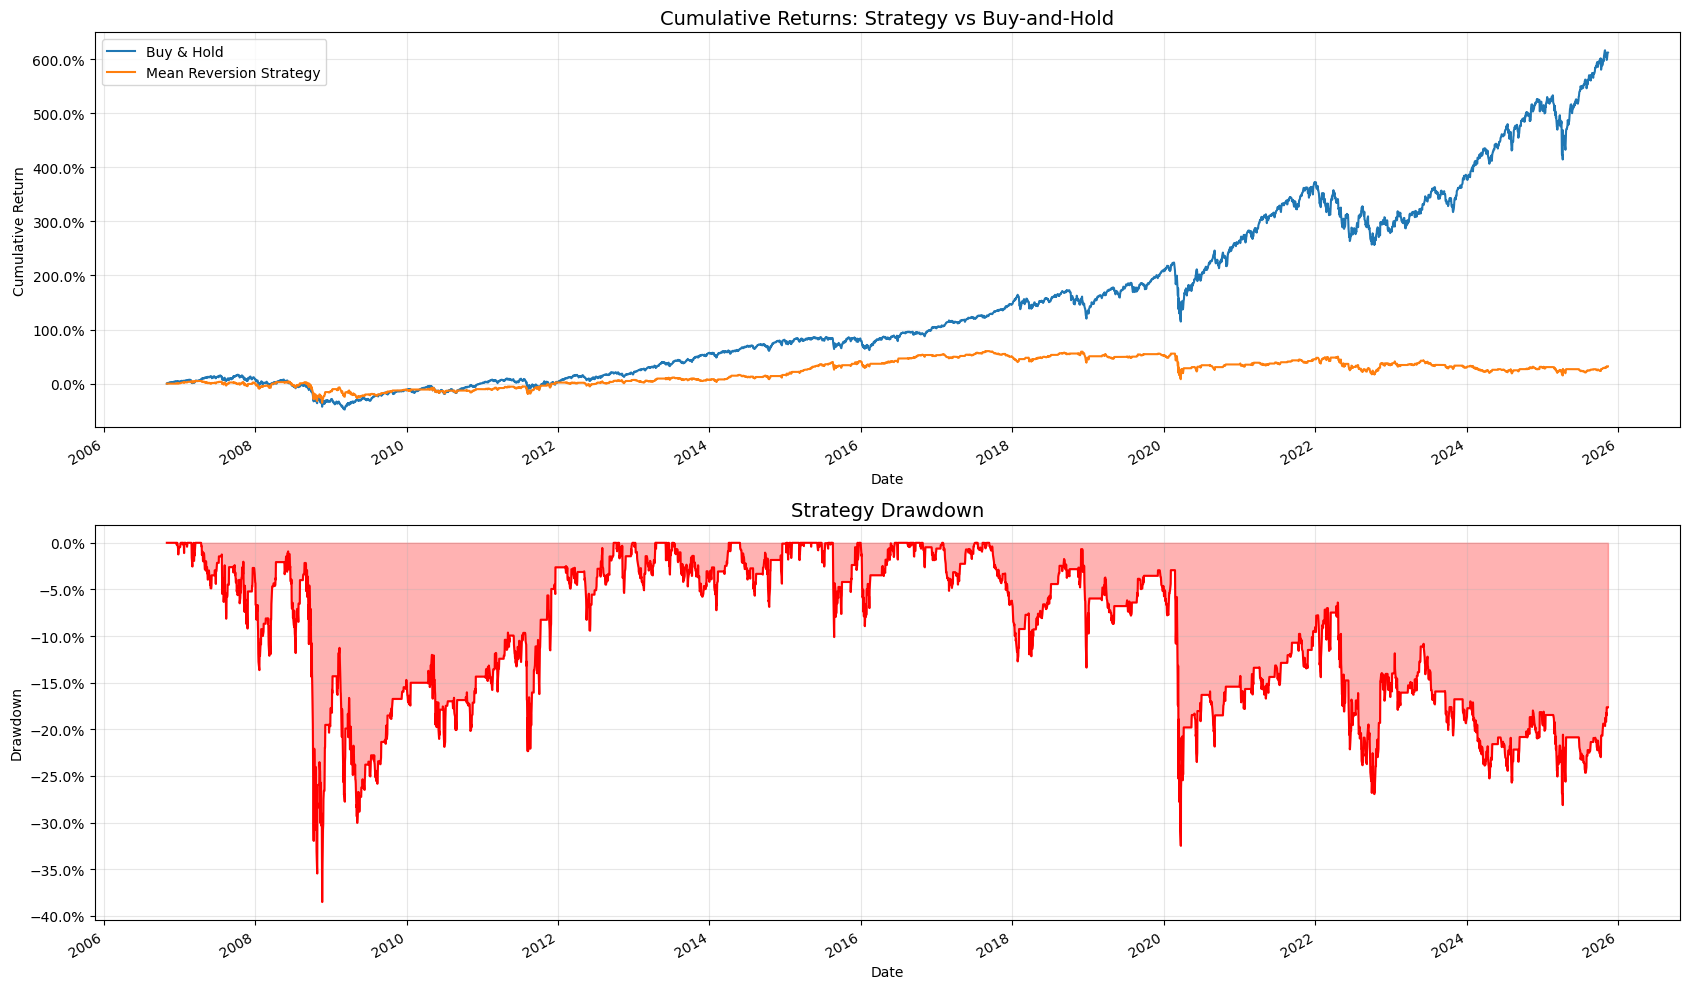

In [10]:
# Example 2: Capital-based position sizing (dynamic - uses max available capital)
spy_signals_capital = compute_mean_reversion_strategy(
    spy, 
    window=20,
    initial_cash=100000,
    position_sizing_method='capital_based',
    capital_allocation_pct=0.95,  # Use 95% of available capital per trade
    z_threshold_long=0
)
metrics = calculate_performance_metrics(spy_signals_capital, initial_cash=100000)
# Use the capital-based strategy for analysis (or choose spy_signals_fixed)
spy_signals = spy_signals_capital
# Calculate and display performance metrics
metrics = calculate_performance_metrics(spy_signals, initial_cash=100000)
# Full date range
viz_backtest_returns(spy_signals)

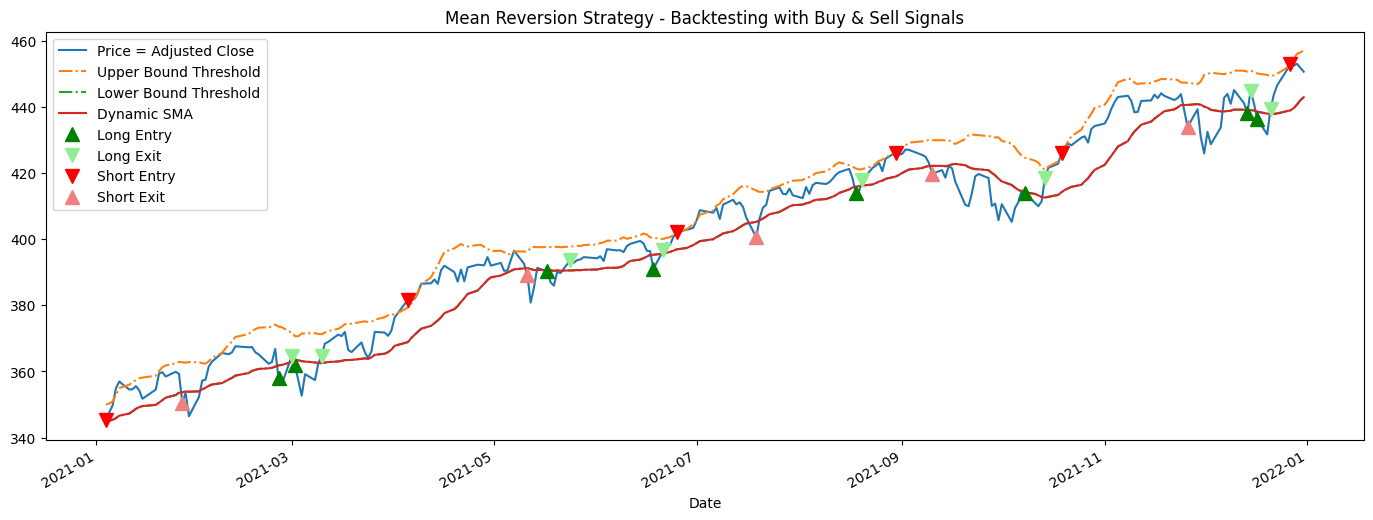

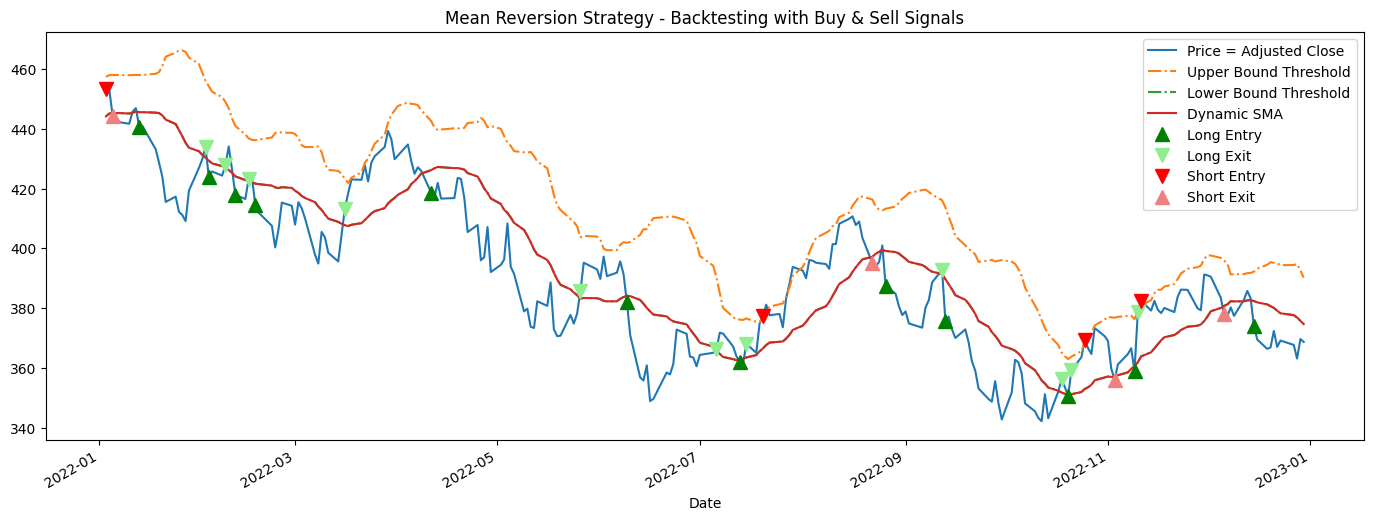

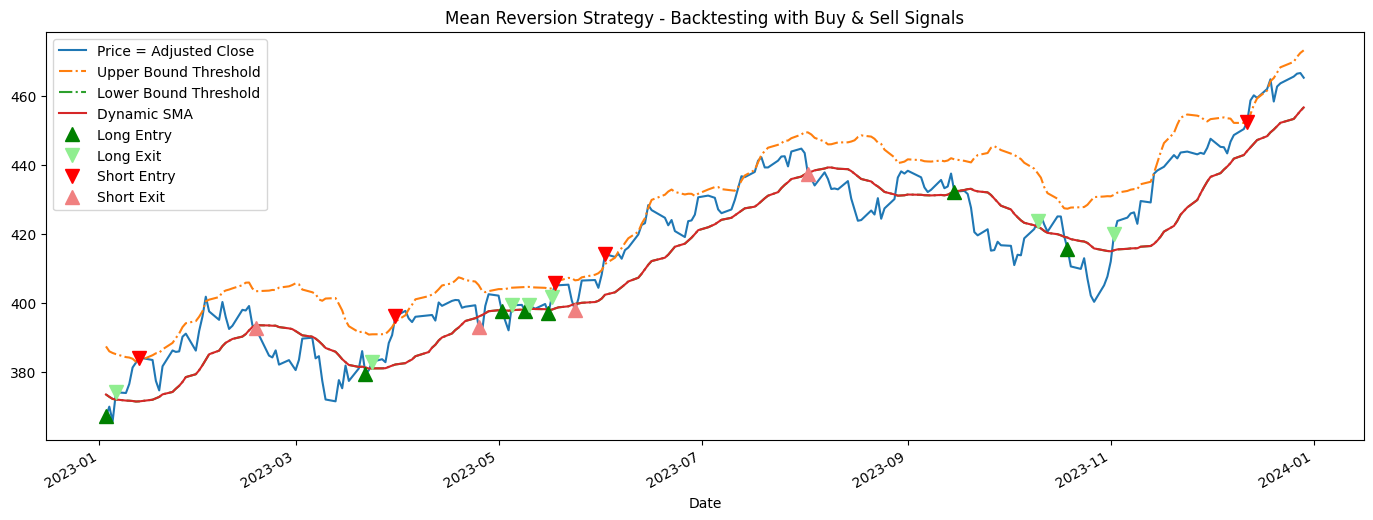

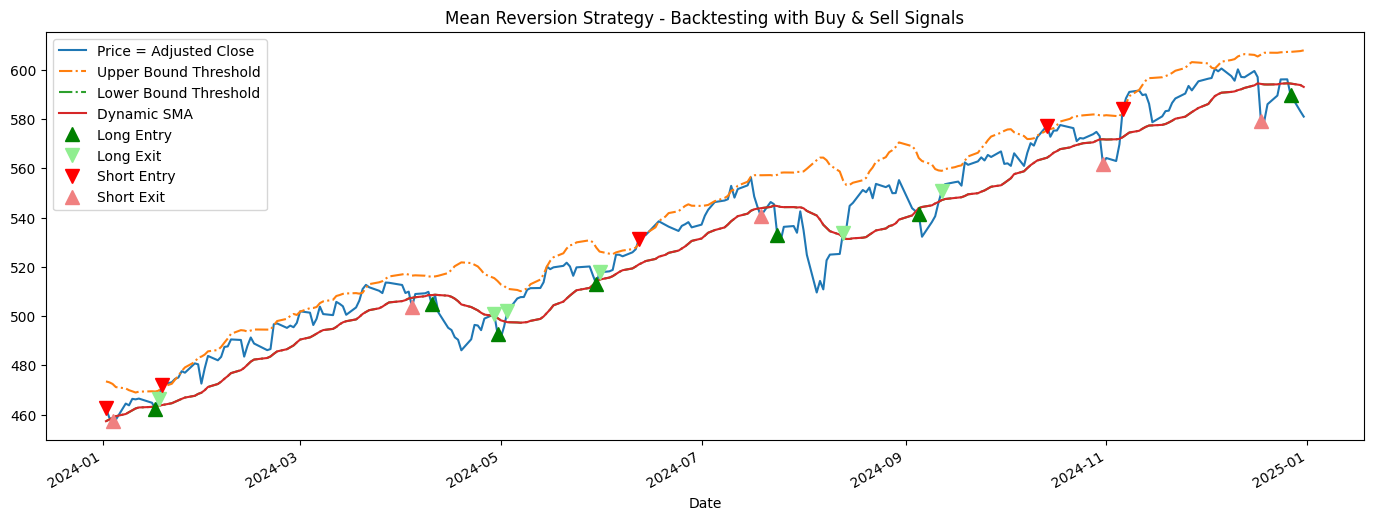

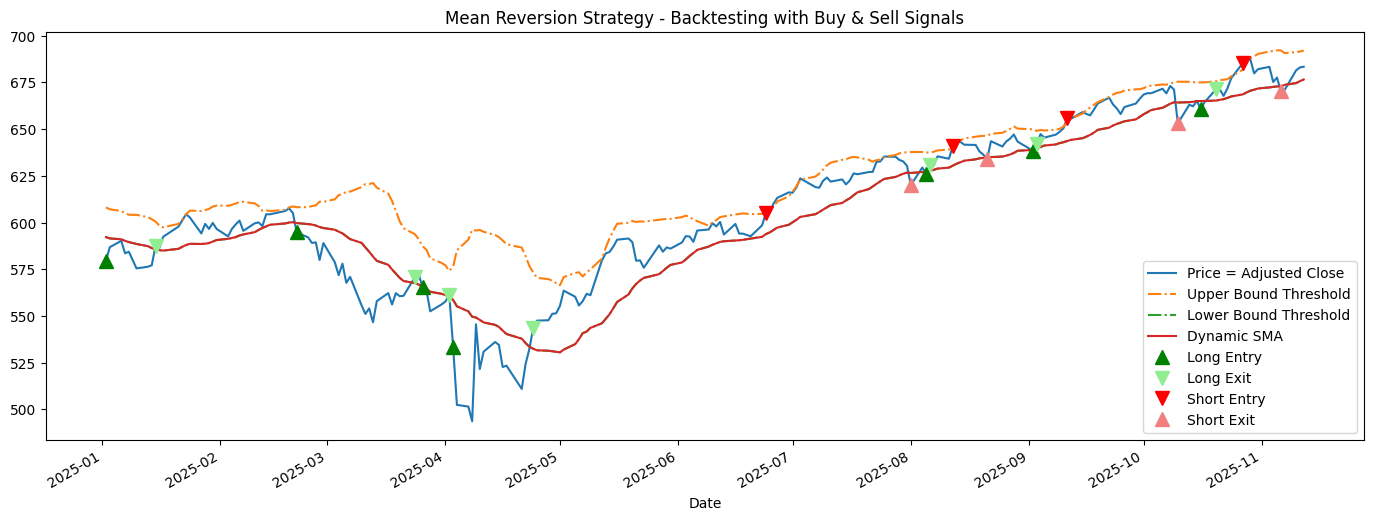

In [11]:
# Last 25% of date range - split by year
total_days = (spy_signals.index[-1] - spy_signals.index[0]).days
last_25_start = spy_signals.index[-1] - pd.Timedelta(days=int(total_days * 0.25))
# Get year range for last 25%
start_year = last_25_start.year
end_year = spy_signals.index[-1].year

# Create separate plot for each year
for year in range(start_year, end_year + 1):
    year_start = f'{year}-01-01'
    year_end = f'{year}-12-31'
    viz_backtest_mean_reversion(spy_signals, start_date=year_start, end_date=year_end)
    



In [12]:
# ============================================================
# TRAIN-TEST SPLIT FOR PROPER BACKTESTING
# ============================================================
# Split data: 75% training, 25% testing (chronological split)

spy = spy_raw.copy()
spy["Adj_Close"] = spy["Close"]
# Calculate split point
total_rows = len(spy)
train_size = int(total_rows * 0.75)

# Split the data chronologically
spy_train = spy.iloc[:train_size].copy()
spy_test = spy.iloc[train_size:].copy()

print(f"\n{'='*70}")
print(f"DATA SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Total Data Points: {total_rows}")
print(f"Training Set: {len(spy_train)} rows ({len(spy_train)/total_rows*100:.1f}%)")
print(f"  - Start Date: {spy_train.index[0].strftime('%Y-%m-%d')}")
print(f"  - End Date:   {spy_train.index[-1].strftime('%Y-%m-%d')}")
print(f"Testing Set:  {len(spy_test)} rows ({len(spy_test)/total_rows*100:.1f}%)")
print(f"  - Start Date: {spy_test.index[0].strftime('%Y-%m-%d')}")
print(f"  - End Date:   {spy_test.index[-1].strftime('%Y-%m-%d')}")
print(f"{'='*70}\n")

display(spy_train)
display(spy_test)


DATA SPLIT SUMMARY
Total Data Points: 4788
Training Set: 3591 rows (75.0%)
  - Start Date: 2006-11-01
  - End Date:   2021-02-08
Testing Set:  1197 rows (25.0%)
  - Start Date: 2021-02-09
  - End Date:   2025-11-12



Price,Close,High,Low,Open,Volume,Adj_Close
Date,,,,,,
2006-11-01,95.973633,96.990449,95.875458,96.927339,83005600,95.973633
2006-11-02,95.917480,96.078766,95.622955,95.728139,60693100,95.917480
2006-11-03,95.749168,96.345238,95.104016,96.261091,71346400,95.749168
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300,96.829132
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900,97.200813
...,...,...,...,...,...,...
2021-02-02,357.220337,358.783861,352.323848,355.441497,64450700,357.220337
2021-02-03,357.501221,359.233261,356.218584,358.053596,52427100,357.501221
2021-02-04,361.564484,361.611284,357.613572,358.540435,47142600,361.564484


Price,Close,High,Low,Open,Volume,Adj_Close
Date,,,,,,
2021-02-09,365.365601,365.964805,364.354480,364.766397,35551100,365.365601
2021-02-10,365.206421,367.266149,362.790948,367.116348,59154400,365.206421
2021-02-11,365.796234,366.713754,363.352675,366.292437,42913300,365.796234
2021-02-12,367.603180,367.846582,364.916163,364.991077,50593300,367.603180
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,367.284851
...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,670.309998
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,670.969971
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,681.440002


In [13]:
# ============================================================
# HYPERPARAMETER OPTIMIZATION ON TRAINING SET
# (technically bruteforce but no forward looking, will deploy ML models in later part of the code)
# ============================================================
# Comprehensive hyperparameter test with PARALLEL PROCESSING ON TRAINING SET
# Uses all CPU cores for much faster execution!
# Set n_jobs=-1 for all cores, or specify number (e.g., n_jobs=4)
results_train = hyperparameter_test(
    spy_train,  # Use TRAINING set only for optimization
    window_range=[5,7,8,9,10, 15, 20, 21, 25, 30, 35, 40, 42, 45, 50],
    z_threshold_long_range=[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0],
    z_threshold_short_range=[0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0],
    position_sizing_methods=['capital_based'],
    initial_cash=100000,
    sort_by='Total Return (%)',  # Can also use: 'CAGR (%)', 'Total Return (%)', 'Max Drawdown (%)' #Sharpe Ratio
    top_n=50,
    verbose=True,
    n_jobs=-1  # Use ALL CPU cores for parallel processing (much faster!)
)


HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 1050 parameter combinations...
Using ALL CPU cores
Started at: 19:37:22



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 19:37:44
Successful tests: 1050/1050


[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:   21.9s finished


In [16]:
# Display top results from TRAINING set
print("\n" + "="*70)
print("TOP 10 STRATEGIES FROM TRAINING SET")
print("="*70)
display(results_train.head(10))

# Save training results to CSV
# script_dir = os.path.dirname(os.path.abspath(__file__))
results_train.to_csv(os.path.join('hyperparameter_results_train.csv'), index=False)
print(f"\nTraining results saved to: {os.path.join('hyperparameter_results_train.csv')}")


TOP 10 STRATEGIES FROM TRAINING SET


,Window,Z_Long,Z_Short,Method,Position_Size,Capital_Alloc_Pct,Total P&L ($),Total Return (%),CAGR (%),Sharpe Ratio,Max Drawdown (%),Volatility (% annualized),Total Trades,Winning Longs,Winning Longs P&L ($),Losing Longs,Losing Longs P&L ($),Final Long P&L ($),Long Win Rate (%),Winning Shorts,Winning Shorts P&L ($),Losing Shorts,Losing Shorts P&L ($),Final Short P&L ($),Short Win Rate (%)
266,9,-1.1,1.75,capital_based,None,0.98,268518.186043,268.518186,9.569346,0.670067,-32.662133,15.687828,296,143,440191.574921,40,-221258.217232,218933.357689,78.142077,68,231649.489059,45,-182064.660706,49584.828354,60.176991
258,9,-1.2,1.75,capital_based,None,0.98,262207.589497,262.207589,9.436825,0.663914,-34.652505,15.632173,286,135,430169.027397,38,-216867.956356,213301.071041,78.034682,68,231851.776802,45,-182945.258347,48906.518456,60.176991
267,9,-1.1,2.00,capital_based,None,0.98,261223.529297,261.223529,9.415967,0.687279,-27.608767,15.010183,236,146,456313.832050,42,-243409.314640,212904.517410,77.659574,32,103046.849533,16,-54727.837646,48319.011887,66.666667
275,9,-1.0,2.00,capital_based,None,0.98,259007.625267,259.007625,9.368804,0.680730,-29.184719,15.113604,246,156,468766.656410,43,-256891.844429,211874.811981,78.391960,31,101940.856850,16,-54808.043564,47132.813286,65.957447
259,9,-1.2,2.00,capital_based,None,0.98,258075.622044,258.075622,9.348886,0.685159,-29.748507,14.952807,227,139,449251.362164,40,-239056.469620,210194.892544,77.653631,32,102926.062958,16,-55045.333458,47880.729500,66.666667
274,9,-1.0,1.75,capital_based,None,0.98,252423.014835,252.423015,9.227044,0.647116,-34.128073,15.768991,302,149,434535.484406,41,-229858.138481,204677.345924,78.421053,67,226619.585201,45,-178873.916290,47745.668911,59.821429
134,7,-1.0,1.75,capital_based,None,0.98,251290.385952,251.290386,9.202411,0.654055,-24.988934,15.527237,329,176,487140.269798,53,-286652.186684,200488.083115,76.855895,62,161453.797146,38,-110651.494308,50802.302837,62.000000
204,8,-1.0,1.75,capital_based,None,0.98,233368.745487,233.368745,8.802493,0.629335,-27.481271,15.536291,321,163,456996.899536,49,-221944.452648,235052.446888,76.886792,62,175537.375504,47,-177221.076904,-1683.701401,56.880734
335,10,-1.1,1.50,capital_based,None,0.98,226160.232243,226.160232,8.635973,0.594872,-32.254559,16.434503,317,119,479186.459938,35,-231218.211735,247968.248203,77.272727,96,381956.619267,67,-403764.635227,-21808.015961,58.895706
257,9,-1.2,1.50,capital_based,None,0.98,223355.211243,223.355211,8.570249,0.591452,-36.574363,16.296480,330,128,454075.233067,36,-225681.249508,228393.983559,78.048780,97,332211.709137,69,-337250.481453,-5038.772316,58.433735



Training results saved to: hyperparameter_results_train.csv



BEST PARAMETERS FROM TRAINING SET
Window: 9
Z-Long Threshold: -1.1
Z-Short Threshold: 1.75
Capital Allocation: 0.98

Training Performance:
  Total Return: 268.52%
  Sharpe Ratio: 0.670
  CAGR: 9.57%
  Max Drawdown: -32.66%


OUT-OF-SAMPLE TEST SET PERFORMANCE

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      23,574.57
Total Return:                       23.57%
CAGR:                                4.55%
Sharpe Ratio:                       0.412
Max Drawdown:                      -18.89%
Volatility (annualized):            12.84%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                          96

----------------------------LONG POSITIONS----------------------------
Winning Longs:                         41 trades
Winning Longs P&L:        $      63,564.48
Losing Longs:                          14 trades
Losing Long

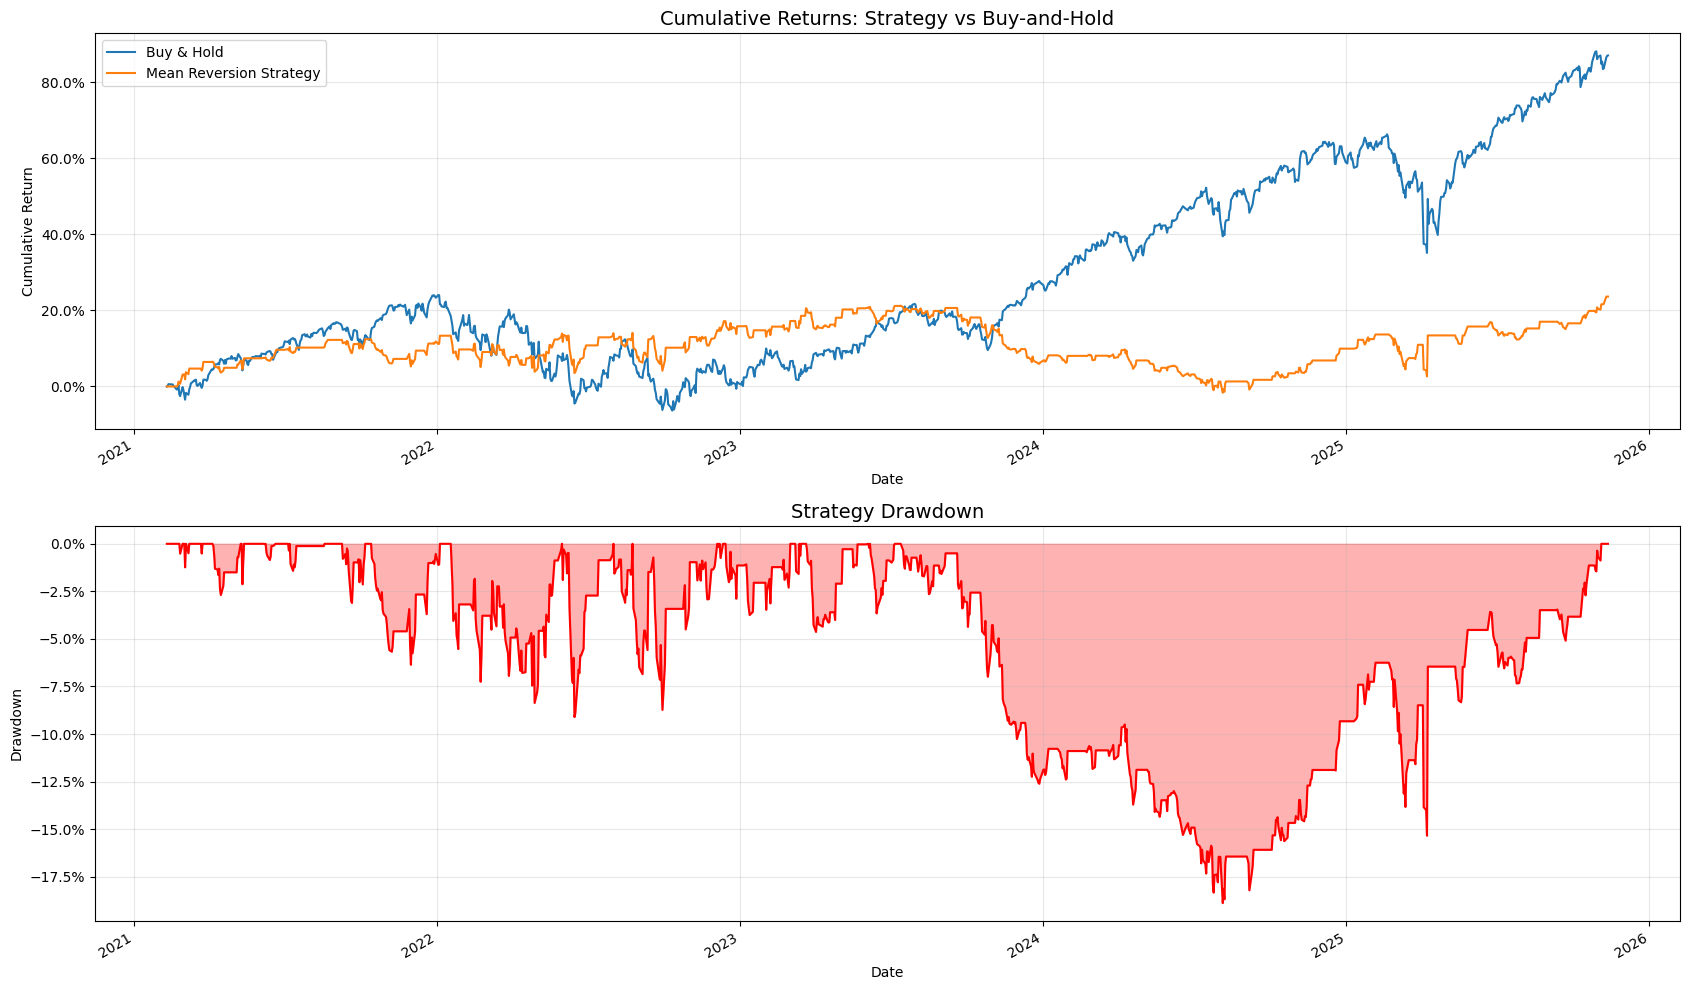

In [17]:
# ============================================================
# TEST BEST PARAMETERS ON TEST SET (OUT-OF-SAMPLE)
# ============================================================

# Extract best parameters from training
best_params = results_train.iloc[0]
print(f"\n{'='*70}")
print(f"BEST PARAMETERS FROM TRAINING SET")
print(f"{'='*70}")
print(f"Window: {best_params['Window']}")
print(f"Z-Long Threshold: {best_params['Z_Long']}")
print(f"Z-Short Threshold: {best_params['Z_Short']}")
print(f"Capital Allocation: {best_params['Capital_Alloc_Pct']}")
print(f"\nTraining Performance:")
print(f"  Total Return: {best_params['Total Return (%)']:.2f}%")
print(f"  Sharpe Ratio: {best_params['Sharpe Ratio']:.3f}")
print(f"  CAGR: {best_params['CAGR (%)']:.2f}%")
print(f"  Max Drawdown: {best_params['Max Drawdown (%)']:.2f}%")
print(f"{'='*70}\n")

# Test on TEST set with best parameters
spy_test_signals = compute_mean_reversion_strategy(
    spy_test,
    window=int(best_params['Window']),
    initial_cash=100000,
    z_threshold_long=best_params['Z_Long'],
    z_threshold_short=best_params['Z_Short'],
    position_sizing_method='capital_based',
    capital_allocation_pct=best_params['Capital_Alloc_Pct']
)

print("\n" + "="*70)
print("OUT-OF-SAMPLE TEST SET PERFORMANCE")
print("="*70)
test_metrics = calculate_performance_metrics(spy_test_signals, initial_cash=100000)

# Compare train vs test performance
print(f"\n{'='*70}")
print(f"TRAIN vs TEST COMPARISON")
print(f"{'='*70}")
print(f"{'Metric':<30} {'Train':>15} {'Test':>15} {'Difference':>15}")
print(f"{'-'*70}")
print(f"{'Total Return (%):':<30} {best_params['Total Return (%)']:>15,.2f} {test_metrics['Total Return (%)']:>15,.2f} {test_metrics['Total Return (%)'] - best_params['Total Return (%)']:>15,.2f}")
print(f"{'Sharpe Ratio:':<30} {best_params['Sharpe Ratio']:>15,.3f} {test_metrics['Sharpe Ratio']:>15,.3f} {test_metrics['Sharpe Ratio'] - best_params['Sharpe Ratio']:>15,.3f}")
print(f"{'CAGR (%):':<30} {best_params['CAGR (%)']:>15,.2f} {test_metrics['CAGR (%)']:>15,.2f} {test_metrics['CAGR (%)'] - best_params['CAGR (%)']:>15,.2f}")
print(f"{'Max Drawdown (%):':<30} {best_params['Max Drawdown (%)']:>15,.2f} {test_metrics['Max Drawdown (%)']:>15,.2f} {test_metrics['Max Drawdown (%)'] - best_params['Max Drawdown (%)']:>15,.2f}")
print(f"{'='*70}\n")

# Visualize test set performance
viz_backtest_returns(spy_test_signals)


FULL DATASET PERFORMANCE (2006-2025)

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $     355,501.83
Total Return:                      355.50%
CAGR:                                8.29%
Sharpe Ratio:                       0.613
Max Drawdown:                      -32.66%
Volatility (annualized):            15.03%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                         392

----------------------------LONG POSITIONS----------------------------
Winning Longs:                        184 trades
Winning Longs P&L:        $     674,749.57
Losing Longs:                          54 trades
Losing Longs P&L:         $    -337,337.82
Final Long P&L:           $     337,411.75
Long Win Rate:                      77.31%

---------------------------SHORT POSITIONS----------------------------
Winning Shorts:                  

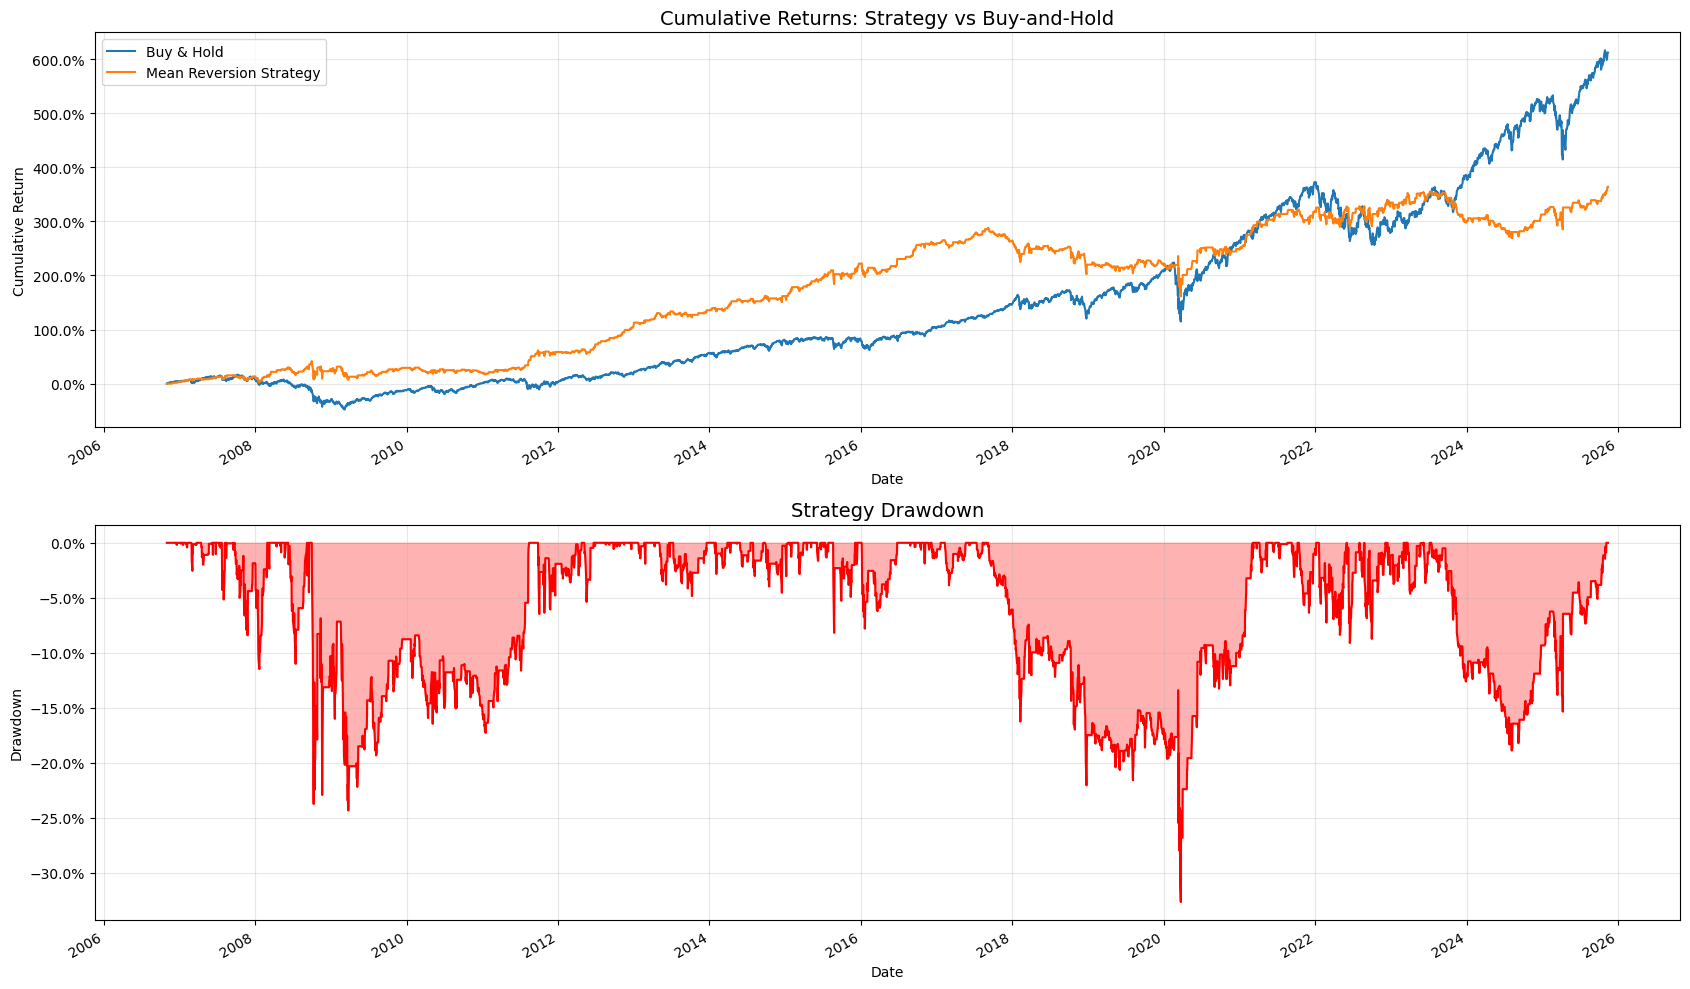


                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $     422,110.84
Total Return:                      422.11%
CAGR:                                9.07%
Sharpe Ratio:                       0.696
Max Drawdown:                      -33.66%
Volatility (annualized):            14.19%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                         432

----------------------------LONG POSITIONS----------------------------
Winning Longs:                        315 trades
Winning Longs P&L:        $     910,906.76
Losing Longs:                         105 trades
Losing Longs P&L:         $    -492,350.68
Final Long P&L:           $     418,556.08
Long Win Rate:                      75.00%

---------------------------SHORT POSITIONS----------------------------
Winning Shorts:                         7 trades
Winning Shorts P&L:   

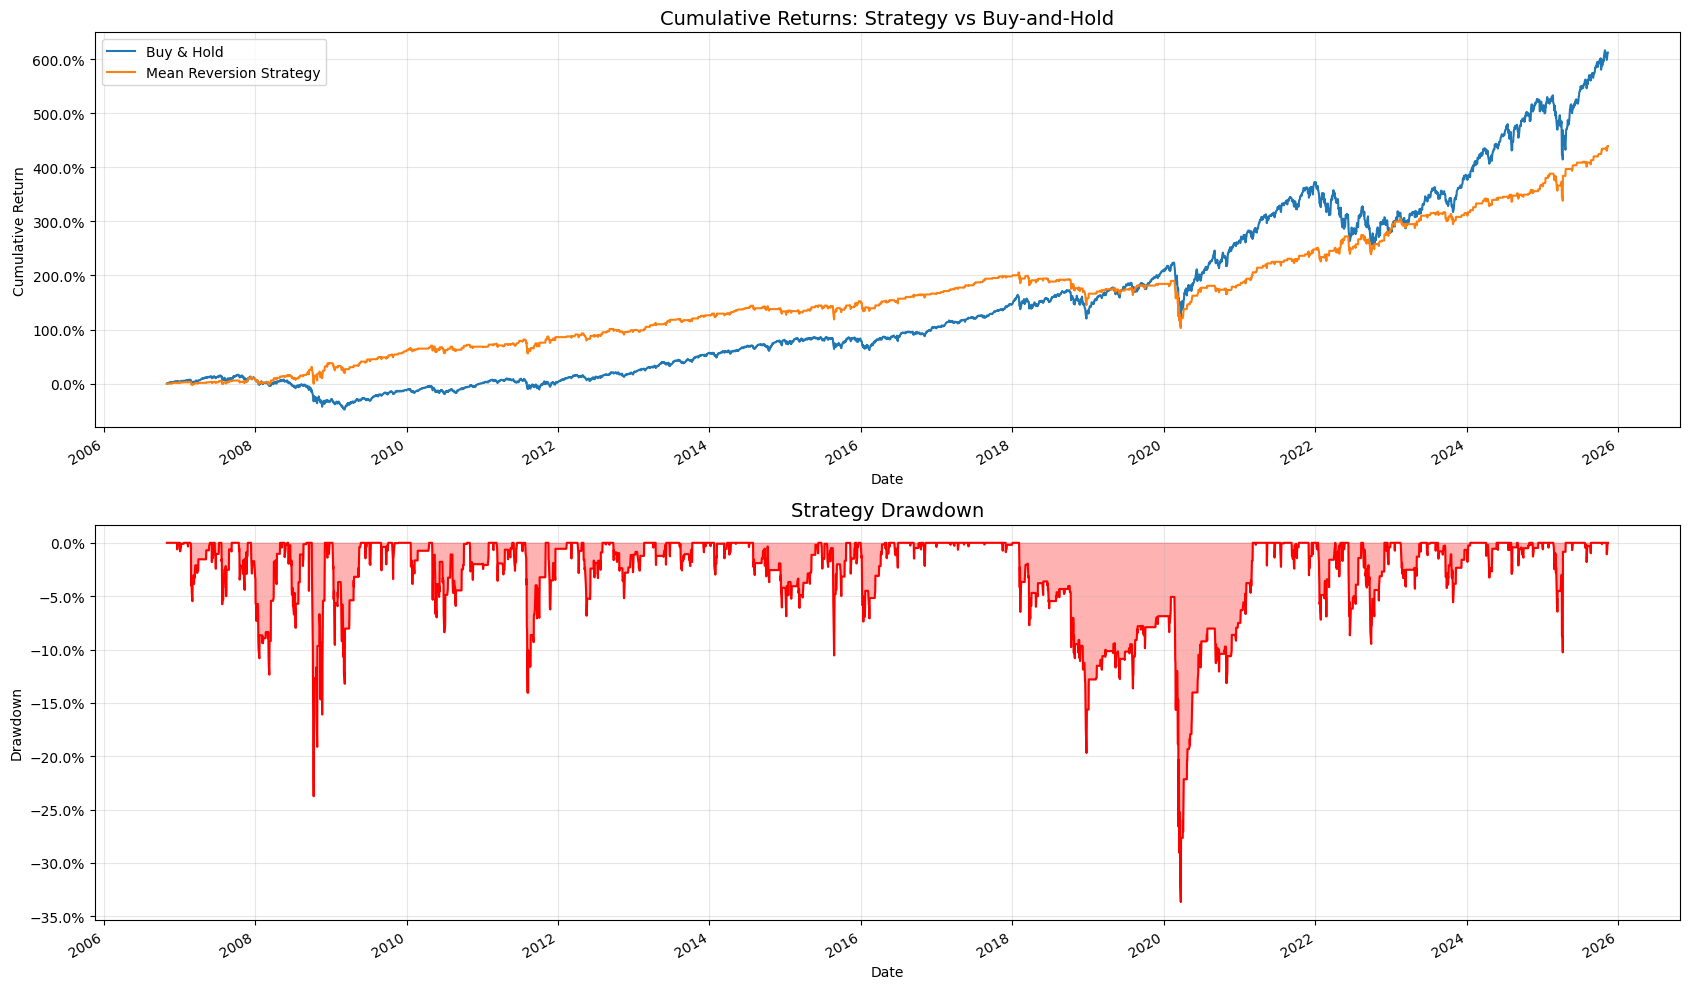

In [18]:
# Test on FULL dataset with best parameters (for comparison)
spy_full_signals = compute_mean_reversion_strategy(
    spy,
    window=int(best_params['Window']),
    initial_cash=100000,
    z_threshold_long=best_params['Z_Long'],
    z_threshold_short=best_params['Z_Short'],
    position_sizing_method='capital_based',
    capital_allocation_pct=best_params['Capital_Alloc_Pct']
)

print("\n" + "="*70)
print("FULL DATASET PERFORMANCE (2006-2025)")
print("="*70)
full_metrics = calculate_performance_metrics(spy_full_signals, initial_cash=100000)
viz_backtest_returns(spy_full_signals)

# %%# Example 2: Capital-based position sizing (dynamic - uses max available capital)
spy_signals_capital = compute_mean_reversion_strategy(
    spy, 
    window=5,
    initial_cash=100000,
    position_sizing_method='capital_based',
    capital_allocation_pct=0.98,  # Use 95% of available capital per trade
    z_threshold_long= -1,
    z_threshold_short=1.75
)
metrics = calculate_performance_metrics(spy_signals_capital, initial_cash=100000)
# Use the capital-based strategy for analysis (or choose spy_signals_fixed)
spy_signals = spy_signals_capital
# Calculate and display performance metrics
metrics = calculate_performance_metrics(spy_signals, initial_cash=100000)
# Full date range
viz_backtest_returns(spy_signals)



In [19]:
# ============================================================
# HYPERPARAMETER OPTIMIZATION ON TEST SET (FORWARD-LOOKING)
# Note: This is for analysis purposes - shows optimal params for test period
# ============================================================

results_test = hyperparameter_test(
    spy_test,  # Run on TEST set
    window_range=[5,7,8,9,10, 15, 20, 21, 25, 30, 35, 40, 42, 45, 50],
    z_threshold_long_range=[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0],
    z_threshold_short_range=[0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0],
    position_sizing_methods=['capital_based'],
    initial_cash=100000,
    sort_by='Total Return (%)',
    top_n=50,
    verbose=True,
    n_jobs=-1
)


HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 1050 parameter combinations...
Using ALL CPU cores
Started at: 19:38:52



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1193230152130127s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]:


Completed at: 19:38:57
Successful tests: 1050/1050


[Parallel(n_jobs=-1)]: Done 987 out of 1050 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    4.9s finished


In [21]:
# Display top results from TEST set optimization
print("\n" + "="*70)
print("TOP 10 STRATEGIES FROM TEST SET (FORWARD-LOOKING)")
print("="*70)
display(results_test.head(10))

# Save test results to CSV
results_test.to_csv(os.path.join('hyperparameter_results_test.csv'), index=False)
print(f"\nTest results saved to: {os.path.join('hyperparameter_results_test.csv')}")


TOP 10 STRATEGIES FROM TEST SET (FORWARD-LOOKING)


,Window,Z_Long,Z_Short,Method,Position_Size,Capital_Alloc_Pct,Total P&L ($),Total Return (%),CAGR (%),Sharpe Ratio,Max Drawdown (%),Volatility (% annualized),Total Trades,Winning Longs,Winning Longs P&L ($),Losing Longs,Losing Longs P&L ($),Final Long P&L ($),Long Win Rate (%),Winning Shorts,Winning Shorts P&L ($),Losing Shorts,Losing Shorts P&L ($),Final Short P&L ($),Short Win Rate (%)
69,5,-1.0,4.00,capital_based,None,0.98,82621.992065,82.621992,13.500669,1.204190,-10.263202,11.292917,113,90,133754.001923,23,-51132.009857,82621.992065,79.646018,0,0.000000,0,0.000000,0.000000,0.0
68,5,-1.0,3.50,capital_based,None,0.98,82621.992065,82.621992,13.500669,1.204190,-10.263202,11.292917,113,90,133754.001923,23,-51132.009857,82621.992065,79.646018,0,0.000000,0,0.000000,0.000000,0.0
67,5,-1.0,3.00,capital_based,None,0.98,82621.992065,82.621992,13.500669,1.204190,-10.263202,11.292917,113,90,133754.001923,23,-51132.009857,82621.992065,79.646018,0,0.000000,0,0.000000,0.000000,0.0
66,5,-1.0,2.50,capital_based,None,0.98,82621.992065,82.621992,13.500669,1.204190,-10.263202,11.292917,113,90,133754.001923,23,-51132.009857,82621.992065,79.646018,0,0.000000,0,0.000000,0.000000,0.0
65,5,-1.0,2.00,capital_based,None,0.98,82621.992065,82.621992,13.500669,1.204190,-10.263202,11.292917,113,90,133754.001923,23,-51132.009857,82621.992065,79.646018,0,0.000000,0,0.000000,0.000000,0.0
64,5,-1.0,1.75,capital_based,None,0.98,81166.458862,81.166459,13.309847,1.187808,-10.263202,11.300779,114,89,132358.805206,23,-51074.403168,81284.402039,79.464286,1,159.527222,1,-277.470398,-117.943176,50.0
60,5,-1.1,3.50,capital_based,None,0.98,77457.575836,77.457576,12.818076,1.163073,-10.263202,11.146256,105,83,123582.437195,22,-46124.861359,77457.575836,79.047619,0,0.000000,0,0.000000,0.000000,0.0
61,5,-1.1,4.00,capital_based,None,0.98,77457.575836,77.457576,12.818076,1.163073,-10.263202,11.146256,105,83,123582.437195,22,-46124.861359,77457.575836,79.047619,0,0.000000,0,0.000000,0.000000,0.0
59,5,-1.1,3.00,capital_based,None,0.98,77457.575836,77.457576,12.818076,1.163073,-10.263202,11.146256,105,83,123582.437195,22,-46124.861359,77457.575836,79.047619,0,0.000000,0,0.000000,0.000000,0.0
57,5,-1.1,2.00,capital_based,None,0.98,77457.575836,77.457576,12.818076,1.163073,-10.263202,11.146256,105,83,123582.437195,22,-46124.861359,77457.575836,79.047619,0,0.000000,0,0.000000,0.000000,0.0



Test results saved to: hyperparameter_results_test.csv


In [22]:
# Compare best parameters: Train vs Test
print(f"\n{'='*70}")
print(f"PARAMETER COMPARISON: TRAIN vs TEST")
print(f"{'='*70}")
print(f"{'Parameter':<25} {'Train Best':>20} {'Test Best':>20}")
print(f"{'-'*70}")
print(f"{'Window:':<25} {results_train.iloc[0]['Window']:>20} {results_test.iloc[0]['Window']:>20}")
print(f"{'Z-Long Threshold:':<25} {results_train.iloc[0]['Z_Long']:>20.2f} {results_test.iloc[0]['Z_Long']:>20.2f}")
print(f"{'Z-Short Threshold:':<25} {results_train.iloc[0]['Z_Short']:>20.2f} {results_test.iloc[0]['Z_Short']:>20.2f}")
print(f"{'Total Return (%):':<25} {results_train.iloc[0]['Total Return (%)']:>20.2f} {results_test.iloc[0]['Total Return (%)']:>20.2f}")
print(f"{'Sharpe Ratio:':<25} {results_train.iloc[0]['Sharpe Ratio']:>20.3f} {results_test.iloc[0]['Sharpe Ratio']:>20.3f}")
print(f"{'='*70}\n")


PARAMETER COMPARISON: TRAIN vs TEST
Parameter                           Train Best            Test Best
----------------------------------------------------------------------
Window:                                      9                    5
Z-Long Threshold:                        -1.10                -1.00
Z-Short Threshold:                        1.75                 4.00
Total Return (%):                       268.52                82.62
Sharpe Ratio:                            0.670                1.204




BEST PARAMETERS FROM TEST SET OPTIMIZATION (FORWARD-LOOKING)
Window: 5
Z-Long Threshold: -1.0
Z-Short Threshold: 4.0
Capital Allocation: 0.98

Test Performance with Test-Optimized Parameters:
  Total Return: 82.62%
  Sharpe Ratio: 1.204
  CAGR: 13.50%
  Max Drawdown: -10.26%


TEST SET WITH OPTIMAL TEST PARAMETERS (FORWARD-LOOKING)

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      82,621.99
Total Return:                       82.62%
CAGR:                               13.50%
Sharpe Ratio:                       1.204
Max Drawdown:                      -10.26%
Volatility (annualized):            11.29%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                         113

----------------------------LONG POSITIONS----------------------------
Winning Longs:                         90 trades
Winning Longs P&L:        $  

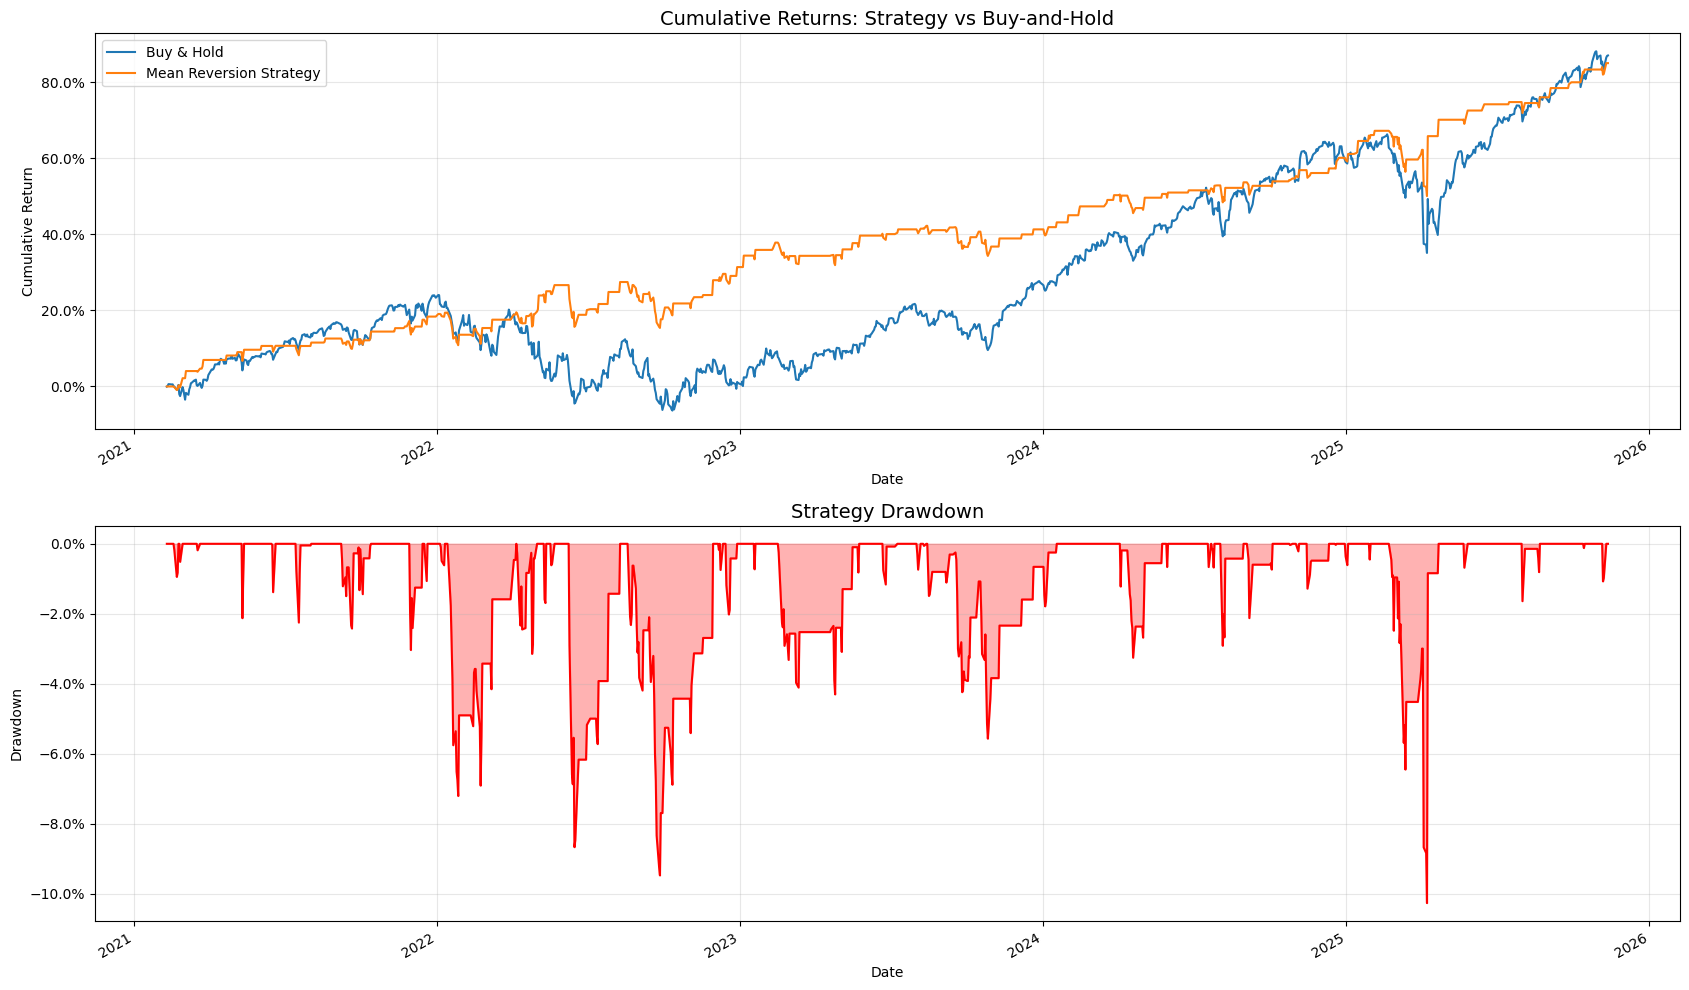

In [23]:
# ============================================================
# RUN TEST SET WITH ITS OPTIMAL PARAMETERS
# ============================================================

# Extract best parameters from test set optimization
best_params_test = results_test.iloc[0]
print(f"\n{'='*70}")
print(f"BEST PARAMETERS FROM TEST SET OPTIMIZATION (FORWARD-LOOKING)")
print(f"{'='*70}")
print(f"Window: {best_params_test['Window']}")
print(f"Z-Long Threshold: {best_params_test['Z_Long']}")
print(f"Z-Short Threshold: {best_params_test['Z_Short']}")
print(f"Capital Allocation: {best_params_test['Capital_Alloc_Pct']}")
print(f"\nTest Performance with Test-Optimized Parameters:")
print(f"  Total Return: {best_params_test['Total Return (%)']:.2f}%")
print(f"  Sharpe Ratio: {best_params_test['Sharpe Ratio']:.3f}")
print(f"  CAGR: {best_params_test['CAGR (%)']:.2f}%")
print(f"  Max Drawdown: {best_params_test['Max Drawdown (%)']:.2f}%")
print(f"{'='*70}\n")

# Run strategy on TEST set with test-optimized parameters
spy_test_optimal_signals = compute_mean_reversion_strategy(
    spy_test,
    window=int(best_params_test['Window']),
    initial_cash=100000,
    z_threshold_long=best_params_test['Z_Long'],
    z_threshold_short=best_params_test['Z_Short'],
    position_sizing_method='capital_based',
    capital_allocation_pct=best_params_test['Capital_Alloc_Pct']
)

print("\n" + "="*70)
print("TEST SET WITH OPTIMAL TEST PARAMETERS (FORWARD-LOOKING)")
print("="*70)
test_optimal_metrics = calculate_performance_metrics(spy_test_optimal_signals, initial_cash=100000)

# Visualize test set performance with optimal parameters
print("\nVisualizing Test Set with Test-Optimized Parameters:")
viz_backtest_returns(spy_test_optimal_signals)